In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import AutoModel, AutoFeatureExtractor, get_linear_schedule_with_warmup
import numpy as np
import librosa
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score 
import torch.optim as optim
import pandas as pd
import os
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils import load_labels_from_dataset, get_audio_paths


seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value) # Se stai usando la GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Controlla se la GPU è disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Using device: cuda


In [4]:
class AudioDepressionDataset(Dataset):
    def __init__(self, audio_paths, labels, model_name, sample_rate=16_000, segment_length_seconds=20, max_segments=None):
        self.audio_paths = audio_paths  
        self.labels = labels            
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name, do_normalize=False)
        self.sample_rate = sample_rate
        self.segment_length_seconds = segment_length_seconds
        self.segment_length_samples = segment_length_seconds * sample_rate
        self.max_segments = max_segments

    def __len__(self):
        return len(self.audio_paths)
    
    def _load_audio(self, audio_path):
        audio, _ = librosa.load(audio_path, sr=self.sample_rate)
        if len(audio.shape) > 1:
            audio = audio.mean(axis=0)
        audio = audio / np.max(np.abs(audio))
        return audio
    
    def _segment_audio(self, audio):
        """Segmenta l'audio in chunks di lunghezza fissa"""
        segments = []
        
        # Se l'audio è più corto del segmento desiderato, pad con zeri
        if len(audio) < self.segment_length_samples:
            padded_audio = np.zeros(self.segment_length_samples)
            padded_audio[:len(audio)] = audio
            segments.append(padded_audio)
        else:
            # Dividi in segmenti
            for i in range(0, len(audio), self.segment_length_samples):
                segment = audio[i:i + self.segment_length_samples]
                
                # Se l'ultimo segmento è troppo corto, pad con zeri
                if len(segment) < self.segment_length_samples:
                    padded_segment = np.zeros(self.segment_length_samples)
                    padded_segment[:len(segment)] = segment
                    segment = padded_segment
                
                segments.append(segment)
                
                # Limita il numero di segmenti se specificato
                if self.max_segments and len(segments) >= self.max_segments:
                    break
        
        return np.array(segments)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        
        audio = self._load_audio(audio_path)
        segments = self._segment_audio(audio)
        
        segment_features = []
        for segment in segments:
            features = self.feature_extractor(
                segment, 
                sampling_rate=self.sample_rate,
                max_length=self.segment_length_samples,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
                return_attention_mask=True,
            )
            segment_features.append(features.input_values[0])
        
        segment_features = torch.stack(segment_features)  # (num_segments, seq_len)
        
        return {
            'input_values': segment_features, 
            'label': torch.tensor(label, dtype=torch.long),
            'num_segments': len(segments)
        }

In [5]:
class AttentionPoolingLayer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.linear = nn.Linear(embed_dim, 1)
        
    def forward(self, x, mask=None):
        """
        Forward pass.
        Args:
            x: The input tensor of shape (batch_size, seq_len, embed_dim).
            mask: The padding mask of shape (batch_size, seq_len).
        Returns:
            The output tensor of shape (batch_size, embed_dim).
        """
        weights = self.linear(x)  # (bs, seq_len, embed_dim) -> (bs, seq_len, 1)

        # Apply the mask before softmax to ignore padding
        if mask is not None:
            # .unsqueeze(-1): (bs, seq_len) -> (bs, seq_len, 1)
            # Assign a very negative value where the mask is True (padding)
            weights.masked_fill_(mask.unsqueeze(-1), -1e9)

        weights = torch.softmax(weights, dim=1)  # Now masked elements will have ~0 weight

        # Weighted sum (bs, seq_len, 1) * (bs, seq_len, embed_dim) -> (bs, embed_dim)
        x = torch.sum(weights * x, dim=1) 
        return x

In [6]:
class DepressionClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout=0.1, 
                 seq_model_type='bilstm', seq_hidden_size=256):
        super(DepressionClassifier, self).__init__()
    
        # SSL model loading & config
        self.ssl_model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        self.ssl_hidden_size = self.ssl_model.config.hidden_size # e.g. 768

        # Weighted sum of SSL model's hidden layers
        num_ssl_layers = self.ssl_model.config.num_hidden_layers
        layers_to_aggregate = num_ssl_layers + 1 # +1 for the initial embeddings

        self.layer_weights = nn.Parameter(torch.ones(layers_to_aggregate))
        self.layer_norms = nn.ModuleList(
            [nn.LayerNorm(self.ssl_hidden_size) for _ in range(layers_to_aggregate)]
        )
        self.softmax = nn.Softmax(dim=-1)

        # Segment-level pooling
        self.segment_embeddings_pooling = AttentionPoolingLayer(embed_dim=self.ssl_hidden_size)
        self.segment_embedding_dim = self.ssl_hidden_size 

        self.seq_model_type = seq_model_type

        if self.seq_model_type == 'bilstm':
            self.sequence_model = nn.LSTM(
                input_size=self.ssl_hidden_size,
                hidden_size=seq_hidden_size,
                num_layers=2,
                batch_first=True,
                dropout=dropout,
                bidirectional=True
            )
            self.seq_output_dim = seq_hidden_size * 2  # bidirectional
        elif self.seq_model_type == 'transformer':
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=self.ssl_hidden_size,
                nhead=8,  # nhead must be a divisor of ssl_hidden_size (e.g. 768 % 8 == 0)
                dim_feedforward=seq_hidden_size * 2, # Common practice
                dropout=dropout,
                activation='relu',
                batch_first=True 
            )
            self.sequence_model = nn.TransformerEncoder(encoder_layer, num_layers=2)
            self.seq_output_dim = self.ssl_hidden_size

        self.audio_embedding_pooling = AttentionPoolingLayer(embed_dim=self.seq_output_dim)
        self.audio_embedding_dim = self.seq_output_dim

        self.classifier = nn.Sequential(
            nn.Linear(self.audio_embedding_dim, self.ssl_hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(self.ssl_hidden_size, num_classes),
        )

        self.init_weights()
    
    def init_weights(self):
        # initialize weights of classifier
        for name, param in self.classifier.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)


    def forward(self, batch):
        input_values = batch['input_values']
        attention_mask = batch.get('attention_mask', None) 
        batch_size, num_segments, seq_len = input_values.shape
        
        # Reshape from (bs, num_segments, seq_len) to (bs * num_segments, seq_len)
        # This allows processing all segments from all audio files in one go.
        input_values_flat = input_values.view(batch_size * num_segments, seq_len)
        
        ssl_hidden_states = self.ssl_model(
            input_values=input_values_flat,
            return_dict=True,
        ).hidden_states  # (bs * num_segments, num_frames, hidden_size)

        # Combine all hidden layers from the SSL model using learned weights.
        ssl_hidden_state = torch.zeros_like(ssl_hidden_states[-1])  # (bs * num_segments, num_frames, hidden_size)
        weights = self.softmax(self.layer_weights)
        for i in range(len(ssl_hidden_states)):
            ssl_hidden_state += weights[i] * self.layer_norms[i](ssl_hidden_states[i])

        # Pool the sequence of frames into a single representation for the whole segment.
        segment_embeddings_flat = self.segment_embeddings_pooling(ssl_hidden_state)  # (bs * num_segments, segment_embedding_dim)

        # Un-flatten the batch to restore sequence structure 
        # Reshape from (bs * num_segments, segment_embedding_dim) back to (bs, num_segments, segment_embedding_dim)
        segment_embeddings = segment_embeddings_flat.view(batch_size, num_segments, self.segment_embedding_dim)

        # Sequence modeling across segments
        # Process the sequence of segment embeddings for each audio file.
        if self.seq_model_type == 'bilstm':
            sequence_output, _ = self.sequence_model(segment_embeddings)
        elif self.seq_model_type == 'transformer':
            sequence_output = self.sequence_model(segment_embeddings, src_key_padding_mask=attention_mask)
        # Result shape: (bs, num_segments, seq_output_dim)
        
        # Pool the sequence of segments into a single representation for the whole audio file.
        audio_embeddings = self.audio_embedding_pooling(sequence_output, mask=attention_mask)  # (bs, audio_embedding_dim)

        output = self.classifier(audio_embeddings)  # (bs, num_classes)

        return output

In [7]:
def collate_fn(batch):
    """
    Questa funzione serve perché diversi audio possono avere numero diverso di segmenti.
    Ad esempio:
    - Audio 1: 30 secondi → 3 segmenti da 10s
    - Audio 2: 50 secondi → 5 segmenti da 10s
    
    Per creare un batch uniforme, dobbiamo fare padding al numero massimo di segmenti.
    Viene chiamata automaticamente dal DataLoader quando batch_size > 1.
    """
    # Trova il numero massimo di segmenti nel batch
    max_segments = max([item['num_segments'] for item in batch])
    
    batch_input_values = []
    batch_labels = []
    batch_masks = []
    
    for item in batch:
        input_values = item['input_values']
        num_segments = item['num_segments']

        mask = torch.zeros(max_segments, dtype=torch.bool)
        mask[num_segments:] = True
        batch_masks.append(mask)

        # Pad se necessario (aggiunge segmenti di zeri)
        if num_segments < max_segments:
            padding_shape = (max_segments - num_segments, input_values.shape[1])
            padding = torch.zeros(padding_shape, dtype=input_values.dtype)
            input_values = torch.cat([input_values, padding], dim=0)
        
        batch_input_values.append(input_values)
        batch_labels.append(item['label'])

    return {
        'input_values': torch.stack(batch_input_values),
        'label': torch.stack(batch_labels),
        'attention_mask': torch.stack(batch_masks)
    }

In [8]:
model_name = "facebook/wav2vec2-base"
num_classes = 2 
dataset_name = "datasets/DAIC-WOZ-Cleaned"

train_df = pd.read_csv(os.path.join(dataset_name, 'train_split_Depression_AVEC2017.csv'))
dev_df = pd.read_csv(os.path.join(dataset_name, 'dev_split_Depression_AVEC2017.csv'))
test_df = pd.read_csv(os.path.join(dataset_name, 'full_test_split.csv'))

y_train = load_labels_from_dataset(train_df)
y_dev = load_labels_from_dataset(dev_df) 
y_test = load_labels_from_dataset(test_df)

train_paths = get_audio_paths(train_df, dataset_name)
dev_paths = get_audio_paths(dev_df, dataset_name)
test_paths = get_audio_paths(test_df, dataset_name)

# Datasets
segment_length_seconds = 4  # Segmenti da 10 secondi
max_segments = 20  # Massimo 138 segmenti (23 minuti max)

train_dataset = AudioDepressionDataset(
    audio_paths=train_paths,
    labels=y_train,
    model_name=model_name,
    segment_length_seconds=segment_length_seconds,
    max_segments=max_segments
)

dev_dataset = AudioDepressionDataset(
    audio_paths=dev_paths,
    labels=y_dev,
    model_name=model_name,
    segment_length_seconds=segment_length_seconds,
    max_segments=max_segments   
)

# DataLoaders
batch_size = 2
num_workers = 0

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=num_workers
)

dev_dataloader = DataLoader(
    dev_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=num_workers
)

# Modello
model = DepressionClassifier(
    model_name=model_name,
    num_classes=num_classes,
    dropout=0.1,
    seq_model_type='bilstm',  # Prova anche 'transformer'
    seq_hidden_size=64
)


C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag

In [9]:
"""
print("\n=== Model Summary ===")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
"""
def print_model_summary(model):
    print("-"*89)
    print(f"| Layer Name                                              | # of Parameters | Trainable |")
    print("-"*89)
    total_num_trainable_params = 0
    for layer_name, layer_params in model.named_parameters():
        if layer_params.requires_grad:
            total_num_trainable_params += layer_params.numel()
        print(f"| {layer_name:<55} | {layer_params.numel():<15} | {str(layer_params.requires_grad):<9} |")
    print("-"*89)
    print(f"| Total # of Parameters: {total_num_trainable_params:<62} |" )
    print("-"*89)

#print_model_summary(model)

Distribuzione delle classi nel training set:
0    77
1    30
Name: count, dtype: int64


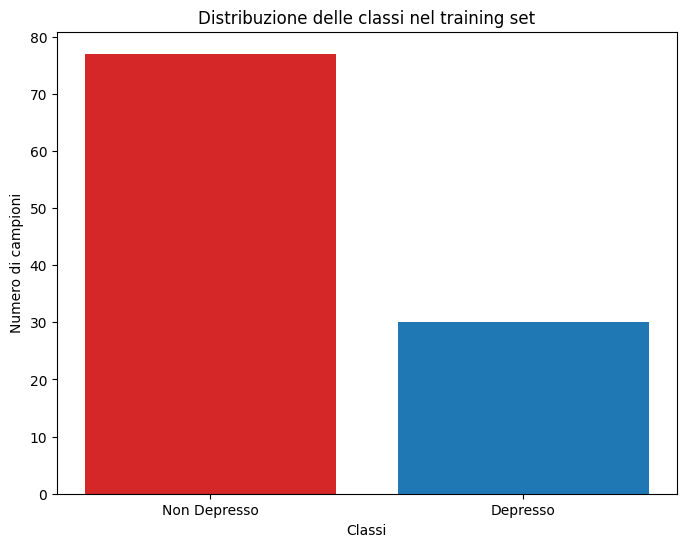

In [10]:
labels_series = pd.Series(y_train)

# Conta il numero di campioni per ciascuna classe
class_distribution = labels_series.value_counts().sort_index()
print("Distribuzione delle classi nel training set:")
print(class_distribution)

label_names = ['Non Depresso', 'Depresso']
counts = [class_distribution.get(i, 0) for i in range(len(label_names))]
plt.figure(figsize=(8, 6))
plt.bar(label_names, counts, color=['tab:red', 'tab:blue', 'tab:green', 'tab:orange'])
plt.xlabel("Classi")
plt.ylabel("Numero di campioni")
plt.title("Distribuzione delle classi nel training set")
plt.show()

In [11]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = -np.inf if mode == 'max' else np.inf

    def __call__(self, current_score):
        if self.mode == 'max':
            improvement = (current_score - self.best_score) > self.min_delta
        else:
            improvement = (self.best_score - current_score) > self.min_delta

        if improvement:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Early stop
        return False

In [12]:
# Funzione di addestramento
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, device,epoch, num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    train_pbar = tqdm(enumerate(train_dataloader), 
                      total=len(train_dataloader),
                      desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for batch_idx, batch in train_pbar:
        # Preleva i dati dal batch
        batch['input_values'] = batch['input_values'].to(device)
        batch['label'] = batch['label'].to(device)
        if 'attention_mask' in batch:
            batch['attention_mask'] = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()

        # Calcolo dei logits grezzi
        outputs = model(batch)

        # Calcolo della loss (i logits vengono passati così come sono)
        loss = loss_fn(outputs, batch['label'])
        total_loss += loss.item()

        # Calcolo delle predizioni: per multi-classe usiamo argmax sui logits
        softmax = nn.LogSoftmax(dim=1)
        preds = softmax(outputs).argmax(dim=1)
        correct_predictions += torch.sum(preds == batch['label'])

        # Backpropagation e aggiornamento dei pesi
        loss.backward()
        optimizer.step()
        scheduler.step()  # Aggiorna lo scheduler se necessario

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return avg_loss, accuracy

# Funzione per validazione
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss, correct_predictions = 0, 0
    predictions, targets = [], []
    with torch.no_grad():
        for batch in data_loader:
            batch['input_values'] = batch['input_values'].to(device)
            batch['label'] = batch['label'].to(device)
            if 'attention_mask' in batch:
                batch['attention_mask'] = batch['attention_mask'].to(device)

            outputs = model(batch)
            loss = loss_fn(outputs,  batch['label'])
            total_loss += loss.item()

            preds = torch.argmax(outputs,dim=1)
            correct_predictions += torch.sum(preds == batch['label'])

            predictions.extend(preds.cpu().numpy())
            targets.extend(batch['label'].cpu().numpy())

    f1 = f1_score(targets, predictions, average='macro')
    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset), f1

In [13]:
# Ottimizzatore e loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, min_delta=0.005, mode='max')
model_save_path = "depression_classifier_best.pth"

model = model.to(device)

# Scheduler per il learning rate
num_epochs = 10
total_steps  = len(train_dataloader) * num_epochs
num_warmup_steps = total_steps // 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)
best_val_f1 = -np.inf
for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch + 1}/{num_epochs} ===")
    
    # Training
    train_loss, train_acc = train_epoch(
        model, 
        train_dataloader, 
        criterion, 
        optimizer, 
        scheduler, 
        device,
        epoch,
        num_epochs
    )
    
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    val_loss, val_acc, val_f1 = eval_model(
        model, 
        dev_dataloader, 
        criterion, 
        device
    )
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}")
    # Salvataggio miglior modello
    if val_f1 > best_val_f1 + early_stopping.min_delta:
        best_val_f1 = val_f1 
        best_model_weights = model.state_dict().copy()
        print(f"Nuovo miglior F1: {best_val_f1:.4f}")

    if early_stopping(val_f1):
        print(f"Early stopping attivato. Miglior F1: {best_val_f1:.4f}")
        break
print("Training Completato")
print(f"Miglior F1 Score: {best_val_f1:.4f}")
torch.save(model.state_dict(), model_save_path)


=== Epoch 1/10 ===


Epoch 1/10 - Training:   0%|          | 0/54 [00:00<?, ?it/s]C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 1/10 - Training: 100%|██████████| 54/54 [04:24<00:00,  4.89s/it]


Train Loss: 0.6242, Train Accuracy: 0.7196
Validation Loss: 0.6445, Validation Accuracy: 0.6571, Validation F1: 0.3966
Nuovo miglior F1: 0.3966

=== Epoch 2/10 ===


Epoch 2/10 - Training:   0%|          | 0/54 [00:00<?, ?it/s]C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 2/10 - Training: 100%|██████████| 54/54 [04:19<00:00,  4.81s/it]


Train Loss: 0.6062, Train Accuracy: 0.7196
Validation Loss: 0.6382, Validation Accuracy: 0.6571, Validation F1: 0.3966

=== Epoch 3/10 ===


Epoch 3/10 - Training:   0%|          | 0/54 [00:00<?, ?it/s]C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Epoch 3/10 - Training:  28%|██▊       | 15/54 [02:14<05:50,  8.99s/it]


KeyboardInterrupt: 

In [ ]:
"""# Training loop
num_epochs = 5
model.to(device)

early_stopping = EarlyStopping(patience=3, min_delta=0.01, mode='max')
best_val_accuracy = 0.0
model_save_path = "depression_classifier_best.pth"

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_pbar = tqdm(enumerate(train_dataloader), 
                      total=len(train_dataloader),
                      desc=f"Epoch {epoch+1}/{num_epochs} - Training")

    print(f"\nEpoch {epoch}")
    
    for batch_idx, batch in train_pbar:
        batch['input_values'] = batch['input_values'].to(device)
        batch['label'] = batch['label'].to(device)
        if 'attention_mask' in batch:
            batch['attention_mask'] = batch['attention_mask'].to(device)

        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch['label'])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch} completed. Average Loss: {avg_loss:.4f}")

    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dev_dataloader:
            batch['input_values'] = batch['input_values'].to(device)
            batch['label'] = batch['label'].to(device)
            if 'attention_mask' in batch:
                batch['attention_mask'] = batch['attention_mask'].to(device)
            
            output = model(batch)
            val_loss += criterion(output, batch['label']).item()
            
            predictions = torch.argmax(output, dim=1)
            total += batch['label'].size(0)
            correct += (predictions == batch['label']).sum().item()
    
    val_accuracy = correct / total
    avg_val_loss = val_loss / len(dev_dataloader)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved to {model_save_path} with accuracy: {val_accuracy:.4f}")"""

'# Training loop\nnum_epochs = 5\nmodel.to(device)\n\nearly_stopping = EarlyStopping(patience=3, min_delta=0.01, mode=\'max\')\nbest_val_accuracy = 0.0\nmodel_save_path = "depression_classifier_best.pth"\n\nfor epoch in range(num_epochs):\n    model.train()\n    total_loss = 0\n    train_pbar = tqdm(enumerate(train_dataloader), \n                      total=len(train_dataloader),\n                      desc=f"Epoch {epoch+1}/{num_epochs} - Training")\n\n    print(f"\nEpoch {epoch}")\n    \n    for batch_idx, batch in train_pbar:\n        batch[\'input_values\'] = batch[\'input_values\'].to(device)\n        batch[\'label\'] = batch[\'label\'].to(device)\n        if \'attention_mask\' in batch:\n            batch[\'attention_mask\'] = batch[\'attention_mask\'].to(device)\n\n        optimizer.zero_grad()\n        output = model(batch)\n        loss = criterion(output, batch[\'label\'])\n\n        loss.backward()\n        optimizer.step()\n\n        total_loss += loss.item()\n\n    avg_los

In [14]:

test_dataset = AudioDepressionDataset(
    audio_paths=test_paths,
    labels=y_test,
    model_name=model_name,
    segment_length_seconds=segment_length_seconds,
    max_segments=max_segments
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers
)

# Carica il miglior modello
#model.load_state_dict(best_model_weights)
model.eval()
test_loss, test_acc, test_f1 = eval_model(
    model, 
    test_dataloader, 
    criterion, 
    device
)
print(f"\n=== Test Results ===")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")


C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\anto-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



=== Test Results ===
Test Loss: 0.6051, Test Accuracy: 0.7021, Test F1: 0.4125
